In [1]:
import numpy as np
import scipy as sp
import scipy.sparse.linalg as spsplin
import scipy.sparse as spsp
import matplotlib.pyplot as plt
import networkx as nx
plt.rc("text", usetex=True)
%config InlineBackend.figure_format = 'retina'

In [2]:
import networkx as nx
from collections import defaultdict
import pickle
import collections
from tqdm import tqdm, tnrange, tqdm_notebook

In [3]:
#spsp.save_npz('./wiki-topcats.npz', G)
G = spsp.load_npz('./wiki-topcats.npz')

In [4]:
edges_num = G.nnz
nodes_num = G.shape[0]
edges_num, nodes_num

(28511807, 1791489)

In [5]:
density = edges_num / nodes_num / (nodes_num - 1)
density

8.883757461872955e-06

In [6]:
# INPUT:  G - np.ndarray or sparse matrix
# OUTPUT: A - np.ndarray (of size G.shape) or sparse matrix
def pagerank_matrix(G):
    return G.multiply(1 / G.sum(axis=0))
# def pagerank_matrix(G):
#     A = G
#     A.data /= np.array(G.sum(axis=0)).repeat(np.diff(G.indptr))
#     return A

# INPUT:  A - np.ndarray (2D), x0 - np.ndarray (1D), num_iter - integer (positive)
# OUTPUT: x - np.ndarray (of size x0), l - float, res - np.ndarray (of size num_iter + 1 [include initial guess])
def power_method(A, x0, num_iter): # 5 pts
    x = x0
    res = []
    for _ in range(num_iter):
        l = x.T.dot(A.dot(x)) / x.T.dot(x)
        x_new = A.dot(x)
        x_new = x_new / np.linalg.norm(x_new)
        res.append(np.linalg.norm(x - x_new))
        x = x_new
    return x, l, res

# INPUT:  A - np.ndarray (2D), d - float (from 0.0 to 1.0), x - np.ndarray (1D, size of A.shape[0/1])
# OUTPUT: y - np.ndarray (1D, size of x)
def pagerank_matvec(A, d, x): # 2 pts
    y = d * A.dot(x) + (1 - d) / A.shape[0] * x.sum()
    return y

In [7]:
N = 1000
d = 0.85
A = np.zeros((N, N))
A[np.random.choice(N, N), np.random.choice(N, N)] = 1
A = spsp.csr_matrix(A)
x = np.random.random(N)

%timeit pagerank_matvec(A, d, x)

Ad = d * A + (1 - d) / N * np.ones((N, N))

%timeit Ad.dot(x)

assert np.isclose(pagerank_matvec(A, d, x), Ad.dot(x)).all()

17.8 µs ± 437 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
356 µs ± 15.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
d = 0.85
A = pagerank_matrix(G)
L = spsplin.LinearOperator(A.shape, matvec=lambda x: pagerank_matvec(A, d, x))

In [9]:
%%time
x0 = np.ones(A.shape[0])
num_iter = 250
x, l, res = power_method(L, x0, num_iter)

CPU times: user 3min 33s, sys: 34.9 s, total: 4min 8s
Wall time: 1min 52s


eigenvector: [2.72092889e-05 4.44091686e-04 4.15866190e-04 ... 6.56873025e-05
 6.56873025e-05 6.60508733e-05] eigenvalue: 0.9999999999999987


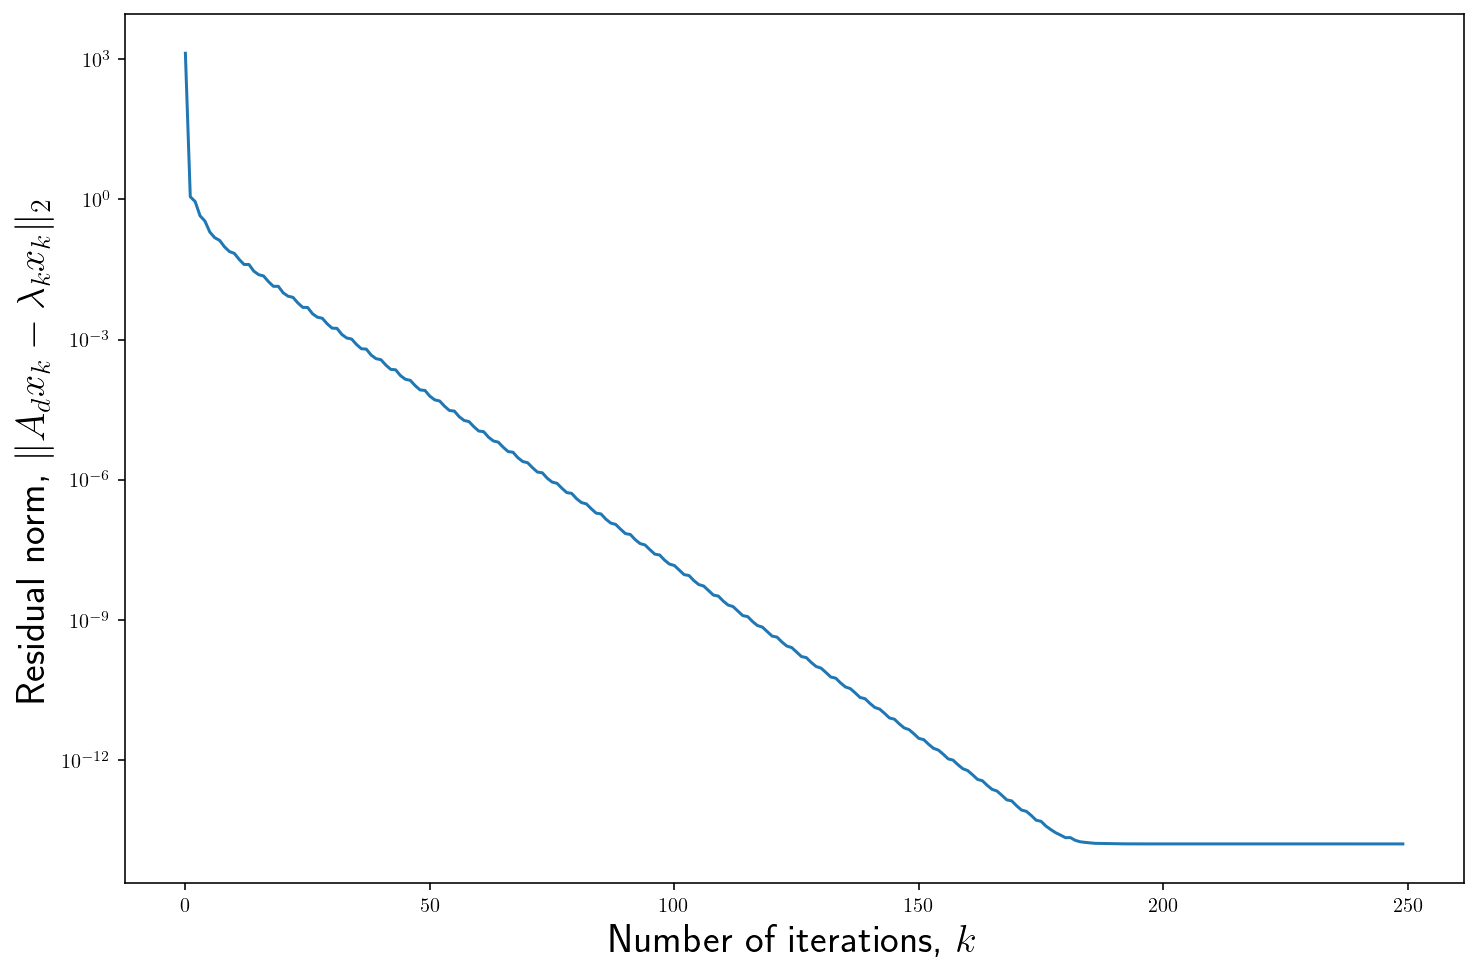

In [10]:
print(f'eigenvector: {x} eigenvalue: {l}')
plt.figure(figsize=(12,8))
plt.xlabel("Number of iterations, $k$", fontsize=20)
plt.ylabel("Residual norm, $\|A_dx_k - \lambda_k x_k\|_2$", fontsize=20)
plt.semilogy(res);

In [11]:
names = {}
with open("./wiki-topcats-page-names.txt", "r") as f:
    for line in f.readlines():
        words = line.split()
        index = words[0]
        name = ' '.join(words[1:])
        names[index] = name

In [12]:
indices = x.argsort()[-20:][::-1]
best_rank = x[indices]
best_names = np.array([names[str(i)] for i in indices])

for n, name in enumerate(best_names):
    print(f'{n + 1}.\t{best_rank[n].round(5)}\t{name}')

1.	0.7371	Cecil Lewis (soccer)
2.	0.30521	Phyllis McCarthy
3.	0.20085	List of University of North Carolina at Chapel Hill alumni
4.	0.09023	Steve Price (musician)
5.	0.08502	1st Arkansas Consolidated Infantry
6.	0.08222	Chiggy Wiggy
7.	0.08144	Tajana Medveck
8.	0.08084	Oakwood, New South Wales
9.	0.07485	SponsorPitch
10.	0.07479	Sterpu River (Lotrioara)
11.	0.07309	Denis O'Donaghue
12.	0.07135	John Baptist Purcell
13.	0.07132	William Henry Elder
14.	0.06936	The Black Dahlia (film)
15.	0.06063	Orneates
16.	0.05938	Bob Hagan
17.	0.05692	Henry Yevele
18.	0.05321	Yul Brynner
19.	0.05297	Walt Brown
20.	0.05232	James Whelan (bishop)


In [13]:
with open("./wiki-topcats-categories.txt", "r") as f2:
    categories = {} # {category0 : [article1, article2, ...], ...., 5: [23, 45, 6]}
    categories_names = {} # {category_name : index, ...}
    categories_names_by_index = {}
    for cat_indx, line in enumerate(f2.readlines()):
        line_content = line.split(";")
        categories[cat_indx] = list(map(int, line_content[1].split()))
        categories_names[line_content[0].split(":")[1]] = cat_indx
        categories_names_by_index[cat_indx] = line_content[0].split(":")[1]

In [14]:
cat_rank = []
for cat_names in categories:   
    cat_rank.append(x[np.array(cat_names)].sum())
cat_rank = np.array(cat_rank)
cat_rank.shape

(17364,)

In [16]:
top_cats = cat_rank.argsort()[-20:][::-1]

for n, i in enumerate(top_cats):
    print(f'{n + 1}.\t{cat_rank[i].round(5)}\t{categories_names_by_index[i]}')

1.	0.01245	Canadian_stage_actors
2.	0.0111	Defunct_New_Jersey_railroads
3.	0.01108	Australian_rules_footballers_from_Victoria
4.	0.01067	Greek_basketball_players
5.	0.0089	Wharton_School_alumni
6.	0.00756	Alkaloids
7.	0.00597	S.C._Braga_players
8.	0.00592	American_baritones
9.	0.00507	Noble_titles
10.	0.00477	Parishes_of_New_Brunswick
11.	0.00468	Copper_minerals
12.	0.0045	Villages_in_South_Yorkshire
13.	0.00415	Hungarian_handball_players
14.	0.00381	Urban_adult_contemporary_radio_stations
15.	0.0038	Players_of_Canadian_football_from_Ontario
16.	0.00374	International_trade
17.	0.00369	Alternative_rock_groups_from_California
18.	0.00363	Buildings_and_structures_with_revolving_restaurants
19.	0.00358	Black_Canadian_musicians
20.	0.00349	History_of_the_Germanic_peoples


In [18]:
for i in x.argsort()[-10:]:
    nonzeros = G[i, :].nonzero()[1]
    adj = [names[str(j)] for j in nonzeros[:5]]
    print(f"{names[str(i)]} nonzero is {nonzeros[:5]}, {adj}, rank {x[i]}")

Sterpu River (Lotrioara) nonzero is [  7  96 104 136 248], ['Annulus theorem', 'Alan Diaz', 'Jeff McDonald', 'Ward Morehouse (activist)', 'The Names'], rank 0.07479268407006137
SponsorPitch nonzero is [528891 531331 549992 637779 764328], ['Polydextrose', 'Uchidachi', '1827 in Ireland', 'Kathy Liebert', 'Anthony Dirrell'], rank 0.07484653230711057
Oakwood, New South Wales nonzero is [  1017   1029   1086 461625 461657], ['Bacterial nanowires', 'Sebastian von Hoerner', 'Jill Wagner', 'Hexham, Victoria', 'Byaduk, Victoria'], rank 0.08084490324088943
Tajana Medveck nonzero is [407431 461566 462832 463585 469804], ['Floyd Hill, Colorado', 'Shire of Tallangatta', 'Nowa Nowa, Victoria', 'Coniston railway station, New South Wales', 'Carol Barnes'], rank 0.08144050024015072
Chiggy Wiggy nonzero is [502202 502930 507590 571857 581167], ['Gonzo Station', 'HMS Opossum (S19)', 'List of birds of The Gambia', 'Sanwell Chirume', 'Michelle Molineux'], rank 0.08221733435723094
1st Arkansas Consolidated

## BFS Shortest path

Breadth-first search (BFS) is an algorithm for traversing or searching tree or graph data structures. It starts at the tree root (or some arbitrary node of a graph, sometimes referred to as a 'search key'), and explores all of the neighbor nodes at the present depth prior to moving on to the nodes at the next depth level.

It uses the opposite strategy as depth-first search, which instead explores the highest-depth nodes first before being forced to backtrack and expand shallower nodes.

BFS and its application in finding connected components of graphs were invented in 1945 by Konrad Zuse, in his (rejected) Ph.D. thesis on the Plankalkül programming language, but this was not published until 1972. It was reinvented in 1959 by Edward F. Moore, who used it to find the shortest path out of a maze, and later developed by C. Y. Lee into a wire routing algorithm (published 1961). Source: Wikipedia.

In [ ]:
def bfs_shortest_path(graph, start, categories_nodes):
    visited_dict = defaultdict(lambda:[False])
    queue = [start]
    visited_dict[start] = 0
    
    while queue:
        node = queue.pop(0)
        distance = visited_dict[node]
        try:
            for neighbour in graph.neighbors(node):
                if visited_dict[neighbour]==[False]:
                    visited_dict[neighbour] = distance + 1
                    queue.append(neighbour)
        except KeyError: pass
    return {node:visited_dict[node] for node in categories_nodes}

With this algorithm we can go through each node of the input category and compute the distances between it and all the other nodes.

In [ ]:
article_distances = {}
counter = 0

for idx, node in enumerate(C0):
    article_distances[node] = bfs_shortest_path(DG, node, categories_nodes)
    if (idx+1)%100==0:
        with open('distance_' + str(counter) + '.pkl', 'wb') as file:
            pickle.dump(article_distances, file, pickle.HIGHEST_PROTOCOL)
        article_distances = dict(); counter+=1

with open('distance_' + str(counter) + '.pkl', 'wb') as file:
    pickle.dump(article_distances, file, pickle.HIGHEST_PROTOCOL)

### Grouping categories with distances computed in the previous step

In [ ]:
distances_categories = {}
    
#for each category selected previously excluding C0
for i in tqdm(final_selected_category_indx):
    distances = []
    #for each node in this selected category underanalysis
    for j in tnrange(35):
        with open(path + 'distance_' + str(j) + '.pkl', 'rb') as file:
            distance_dict = pickle.load(file)
            for node in categories[i]:
                #for the starting node of C0 into our distance file
                for starting_node in distance_dict:
                    #try to find the distances from C0 node to the node inside the category under analysis
                    try:
                        d = distance_dict[starting_node][node]
                        if d != [False]:
                            distances.append(d)
                            #if distance is false append 9999
                        else: distances.append(9999)

                    except: pass
            #append the results of distances to this category
    distances = np.array(distances)
    median = np.median(distances)
    distances_categories[i] = median
    
    print(i, median)